# Customer Churn

Customer Churn

Customers have started leaving "Beta Bank." Every month, the churn rate is noticeable, though not significantly high. Bank marketers have calculated that retaining existing customers is cheaper than acquiring new ones.

The task is to predict whether a customer will leave the bank in the near future. Historical data on customer behavior and contract terminations with the bank has been provided.

Build a model with the highest possible F1-score. To pass the project successfully, the F1-score should be at least 0.59. Verify the F1-score on the test dataset independently.

Additionally, measure the AUC-ROC score and compare it with the F1-score.

Data Source: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**The goal of this project** is to find a classification model with the highest F1-score for predicting customer churn from the bank.

**Features:**
- RowNumber: Index of the row in the data
- CustomerId: Unique identifier of the customer
- Surname: Surname of the customer
- CreditScore: Credit score of the customer
- Geography: Country of residence
- Gender: Gender of the customer
- Age: Age of the customer
- Tenure: Number of years the customer has been with the bank
- Balance: Account balance
- NumOfProducts: Number of bank products used by the customer
- HasCrCard: Whether the customer has a credit card (0 = No, 1 = Yes)
- IsActiveMember: Whether the customer is an active member (0 = No, 1 = Yes)
- EstimatedSalary: Estimated salary of the customer

**Target Variable:**
- Exited: Whether the customer has exited (0 = No, 1 = Yes)

## Data Preparation

In [1]:
pip install pandas_profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 15.3 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27079 sha256=5dab11da4ef026fcf39cf374b84a8a7b67823114e40308fd563caa7b8ffbf2fa
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.8.2.2
    Uninstalling wordc

In [2]:
!pip install scikit-learn==1.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 41.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
!pip install imblearn

In [4]:
import pandas as pd
import warnings
from sklearn.model_selection import (train_test_split, RandomizedSearchCV)
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)
import ydata_profiling as pf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,roc_auc_score,f1_score,precision_score, recall_score)
from imblearn.over_sampling import SMOTE

In [5]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

RANDOM_STATE = 12345

In [6]:
def get_data_info(data):
    display(data.sample(10))
    display(data.info())
    display(data.duplicated().sum())
    display(data.isna().mean().round(4)*100)
    display(data.describe(include='all'))

In [8]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [9]:
get_data_info(data)

RowNumber  CustomerId     Surname  CreditScore Geography  Gender  Age  \
3848       3849    15577831       Byrne          560   Germany    Male   41   
5977       5978    15631639    Uspensky          704    France  Female   40   
4330       4331    15666652   Anayolisa          781    France  Female   19   
7891       7892    15652782     Chibuzo          678   Germany    Male   48   
6468       6469    15677184   Cremonesi          767    France  Female   35   
2023       2024    15731890  Chukwukere          601    France    Male   41   
5951       5952    15590637       Ahmed          721    France    Male   41   
1449       1450    15726556  Macgroarty          594   Germany  Female   26   
2802       2803    15723299    Sorokina          774    France    Male   53   
9978       9979    15703563       P'eng          774    France    Male   40   

      Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
3848     4.0  152532.30              1          0               0   
5977     6.0   95452.89              1          0               1   
4330     3.0       0.00              2          1               1   
7891     2.0  101099.90              2          0               1   
6468     6.0  115576.44              1          0               1   
2023     1.0  123971.16              1          0               1   
5951     7.0       0.00              2          0               1   
1449     NaN  135067.52              2          0               0   
2802     4.0  113709.28              1          1               1   
9978     9.0   93017.47              2          1               0   

      EstimatedSalary  Exited  
3848         10779.69       0  
5977        179964.55       0  
4330        124297.32       0  
7891        193476.04       0  
6468         27922.45       0  
2023        172814.99       0  
5951         61018.85       0  
1449        131211.86       0  
2802        153887.93       1  
9978        191608.97       0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

0

RowNumber          0.00
CustomerId         0.00
Surname            0.00
CreditScore        0.00
Geography          0.00
Gender             0.00
Age                0.00
Tenure             9.09
Balance            0.00
NumOfProducts      0.00
HasCrCard          0.00
IsActiveMember     0.00
EstimatedSalary    0.00
Exited             0.00
dtype: float64

RowNumber    CustomerId Surname   CreditScore Geography Gender  \
count   10000.00000  1.000000e+04   10000  10000.000000     10000  10000   
unique          NaN           NaN    2932           NaN         3      2   
top             NaN           NaN   Smith           NaN    France   Male   
freq            NaN           NaN      32           NaN      5014   5457   
mean     5000.50000  1.569094e+07     NaN    650.528800       NaN    NaN   
std      2886.89568  7.193619e+04     NaN     96.653299       NaN    NaN   
min         1.00000  1.556570e+07     NaN    350.000000       NaN    NaN   
25%      2500.75000  1.562853e+07     NaN    584.000000       NaN    NaN   
50%      5000.50000  1.569074e+07     NaN    652.000000       NaN    NaN   
75%      7500.25000  1.575323e+07     NaN    718.000000       NaN    NaN   
max     10000.00000  1.581569e+07     NaN    850.000000       NaN    NaN   

                 Age       Tenure        Balance  NumOfProducts    HasCrCard  \
count   10000.000000  9091.000000   10000.000000   10000.000000  10000.00000   
unique           NaN          NaN            NaN            NaN          NaN   
top              NaN          NaN            NaN            NaN          NaN   
freq             NaN          NaN            NaN            NaN          NaN   
mean       38.921800     4.997690   76485.889288       1.530200      0.70550   
std        10.487806     2.894723   62397.405202       0.581654      0.45584   
min        18.000000     0.000000       0.000000       1.000000      0.00000   
25%        32.000000     2.000000       0.000000       1.000000      0.00000   
50%        37.000000     5.000000   97198.540000       1.000000      1.00000   
75%        44.000000     7.000000  127644.240000       2.000000      1.00000   
max        92.000000    10.000000  250898.090000       4.000000      1.00000   

        IsActiveMember  EstimatedSalary        Exited  
count     10000.000000     10000.000000  10000.000000  
unique             NaN              NaN           NaN  
top                NaN              NaN           NaN  
freq               NaN              NaN           NaN  
mean          0.515100    100090.239881      0.203700  
std           0.499797     57510.492818      0.402769  
min           0.000000        11.580000      0.000000  
25%           0.000000     51002.110000      0.000000  
50%           1.000000    100193.915000      0.000000  
75%           1.000000    149388.247500      0.000000  
max           1.000000    199992.480000      1.000000

In [10]:
pf.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Let's replace the missing values in the column "Tenure" with a median value.

In [11]:
data['Tenure'].fillna(data['Tenure'].median(), inplace=True)

In the ProfileReport, it can be seen that the parameters Age and NumOfProducts have the highest correlation with the target variable Exited. Let's take a closer look at them.

<Axes: xlabel='Age', ylabel='Count'>

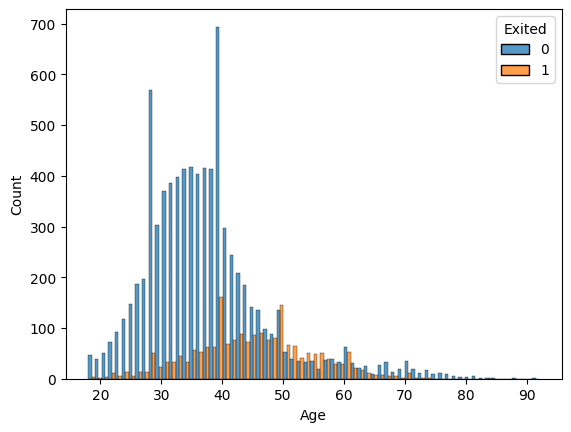

In [12]:
sns.histplot(data=data, x="Age", hue="Exited", multiple="dodge")

<Axes: xlabel='NumOfProducts', ylabel='Count'>

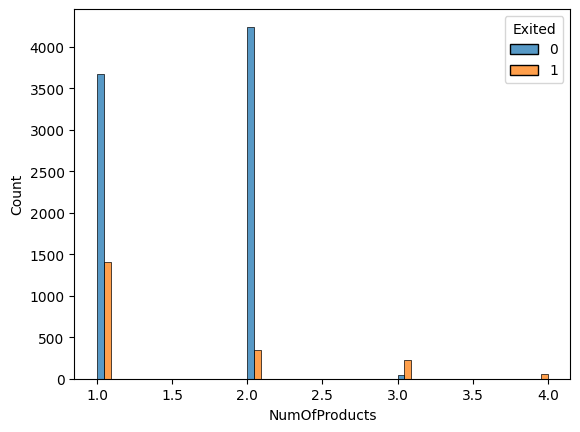

In [13]:
sns.histplot(data=data, x="NumOfProducts", hue="Exited", multiple="dodge")

## Conclusion

- The original dataset does not have any peculiarities that hinder further exploration of the problem.
- Missing values in the Tenure column were processed using median values.
- The highest correlation with the Exited target variable was found for Age and NumOfProducts. Clients older than 45 years and those who use only one banking product are more likely to churn from the bank's services.

## EDA

<Axes: title={'center': 'Class distribution'}>

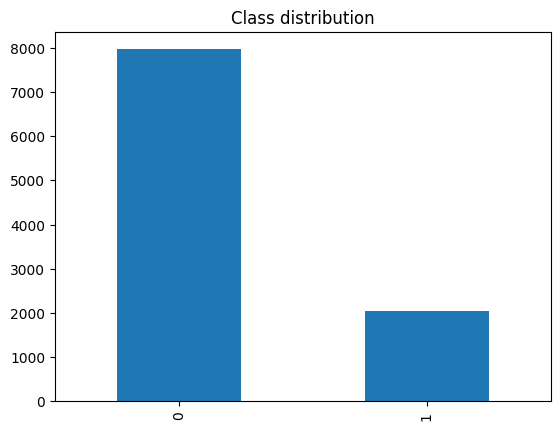

In [14]:
# let's examine the distribution of classes in the target column
data.Exited.value_counts().plot(kind='bar', title = 'Class distribution')

In [15]:
# let's remove the columns that do not affect the values of the "Exited" column
data.drop(['CustomerId', 'Surname', 'RowNumber'], axis=1, inplace=True)

In [16]:
# applying encoding to the remaining categorical values
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

enc_data = pd.DataFrame(enc.fit_transform(data[['Geography','Gender']]).toarray())

# merging encoded data with the rest of the dataframe
data_ohe = data.join(enc_data)
data_ohe.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42     2.0       0.00              1   
1          608     Spain  Female   41     1.0   83807.86              1   
2          502    France  Female   42     8.0  159660.80              3   
3          699    France  Female   39     1.0       0.00              2   
4          850     Spain  Female   43     2.0  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited    0    1    2    3    4  
0          1               1        101348.88       1  1.0  0.0  0.0  1.0  0.0  
1          0               1        112542.58       0  0.0  0.0  1.0  1.0  0.0  
2          1               0        113931.57       1  1.0  0.0  0.0  1.0  0.0  
3          0               0         93826.63       0  1.0  0.0  0.0  1.0  0.0  
4          1               1         79084.10       0  0.0  0.0  1.0  1.0  0.0

In [17]:
# removing the original columns
data_ohe=data_ohe.drop(['Geography','Gender'], axis=1)
data_ohe.head()

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0          619   42     2.0       0.00              1          1   
1          608   41     1.0   83807.86              1          0   
2          502   42     8.0  159660.80              3          1   
3          699   39     1.0       0.00              2          0   
4          850   43     2.0  125510.82              1          1   

   IsActiveMember  EstimatedSalary  Exited    0    1    2    3    4  
0               1        101348.88       1  1.0  0.0  0.0  1.0  0.0  
1               1        112542.58       0  0.0  0.0  1.0  1.0  0.0  
2               0        113931.57       1  1.0  0.0  0.0  1.0  0.0  
3               0         93826.63       0  1.0  0.0  0.0  1.0  0.0  
4               1         79084.10       0  0.0  0.0  1.0  1.0  0.0

In [18]:
# let's separate the target and features and split the dataset into the training and testing sets
target = data_ohe['Exited']
features = data_ohe.drop(['Exited'] , axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

print(features_train.shape)
print(features_test.shape)

(7500, 13)
(2500, 13)


In [19]:
# applying scaling
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']


scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

#### Logistic Regression

In [20]:
# training Logistic Regression model and checking the metrics
model_lr = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model_lr.fit(features_train, target_train)
predicted_test = model_lr.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))
print("ROC_AUC:", roc_auc_score(target_test, predicted_test))

F1: 0.3173216885007277
ROC_AUC: 0.5897447156605511


#### Random Forest Classifier

In [21]:
# training Random Forest model with hyperparamaeter tuning using RandomizedSearchCV
n_estimators = [80,100,120,150]
max_depth = [10,20,30]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 4]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf}

rfc = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=RANDOM_STATE),
                   param_distributions = rf_grid,
                           scoring = 'f1',
                   cv = 5)

rfc.fit(features_train, target_train)

print("Best F1:", rfc.best_score_)
print("Best params:", rfc.best_params_)

Best F1: 0.5754447314953461
Best params: {'n_estimators': 120, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


In [22]:
# training the best model and checking the metrics
model_rfc = rfc.best_estimator_.fit(features_train, target_train)
predicted_test = model_rfc.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5721271393643031
ROC_auc: 0.711027719038226


#### HistGradientBoostingClassifier

In [23]:
from sklearn.ensemble import HistGradientBoostingClassifier

# training HistGradientBoostingClassifier with hyperparamaeter tuning using RandomizedSearchCV
parameters = {
    'learning_rate' : [0.1, 0.01],
    'max_depth':[3,5,8,10,20],
}

hgbc = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

clf_hgbc = RandomizedSearchCV(
    estimator = hgbc,
    param_distributions = parameters,
    scoring = 'f1',
    cv=5)


clf_hgbc.fit(features_train, target_train)

print("Best F1:", clf_hgbc.best_score_)
print("Best params:", clf_hgbc.best_params_)

Best F1: 0.5860901310603228
Best params: {'max_depth': 8, 'learning_rate': 0.1}


In [24]:
# training the best model and checking the metrics
model_hgbc = clf_hgbc.best_estimator_.fit(features_train, target_train)
predicted_test = model_hgbc.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5951557093425606
ROC_auc: 0.7283251054104966


### Conlusion
The best results without correcting class imbalance were achieved using HistGradientBoostingClassifier model:  
- F1: 0.5951557093425606
- ROC_auc: 0.7283251054104966

## Dealing with class imbalance

### Class weighting

#### Logistic Regression

In [25]:
# training LogisticRegression with class weighting
model_lr_balanced = LogisticRegression(random_state=RANDOM_STATE,solver='liblinear', class_weight='balanced')
model_lr_balanced.fit(features_train, target_train)
predicted_test = model_lr_balanced.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5013736263736264
ROC_auc: 0.7123884592651213


#### Random Forest Classifier

In [26]:
# training RandomForestClassifier with class weighting
n_estimators = [80,100,120,150]
max_depth = [10,20,30]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 4]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_split': min_samples_split,
           'min_samples_leaf': min_samples_leaf,
          'class_weight': ['balanced']}

rfc_balanced = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=RANDOM_STATE),
                   param_distributions = rf_grid,
                           scoring = 'f1',
                   cv = 5)

rfc_balanced.fit(features_train, target_train)

print("Best F1:", rfc_balanced.best_score_)
print("Best params:", rfc_balanced.best_params_)

Best F1: 0.6225503529724966
Best params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'class_weight': 'balanced'}


In [27]:
# training the best model and checking the metrics
model_rfc_balanced = rfc_balanced.best_estimator_.fit(features_train, target_train)
predicted_test = model_rfc_balanced.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.6155378486055777
ROC_auc: 0.7568261498945649


When weighting the classes, the metrics significantly improved. The highest F1 score is achieved by the RandomForestClassifier: 0.61, with a ROC_AUC value of 0.76.

### Upsampling

In [28]:
# let's apply the upsampling technique
oversample = SMOTE(random_state=RANDOM_STATE)
features_train_up, target_train_up = oversample.fit_resample(features_train, target_train)

target_train_up.value_counts()

1    5972
0    5972
Name: Exited, dtype: int64

#### Logistic Regression

In [29]:
# let's train the logistic regression model on the upsampled dataset and calculate the metrics on the test set
model_lr_upsampled = LogisticRegression(random_state=RANDOM_STATE,solver='liblinear')
model_lr_upsampled.fit(features_train_up, target_train_up)
predicted_test = model_lr_upsampled.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.49184975194897235
ROC_auc: 0.7014872426903384


#### Random Forest Classifier

In [30]:
%%time
# training the model
model_rfc_up = None
best_f1 = 0
for est in [80,100,120,150]:
    model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=20)
    model.fit(features_train_up,target_train_up)
    predicted_test = model.predict(features_test)
    result = f1_score(target_test, predicted_test)
    if result > best_f1:
        model_rfc_up = model
        best_f1 = result

print("F1:", best_f1)
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.6004016064257028
ROC_auc: 0.7465007070125981
CPU times: user 7.6 s, sys: 118 ms, total: 7.72 s
Wall time: 7.63 s


#### HistGradientBoostingClassifier

In [31]:
# training HistGradientBoostingClassifier
model_hgbc_up = None
best_f1 = 0

for depth in range (1, 50):
    model = HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=depth, learning_rate=0.1)
    model.fit(features_train_up,target_train_up)
    predicted_test = model.predict(features_test)
    result = f1_score(target_test, predicted_test)
    if result > best_f1:
        model_hgbc_up = model
        best_f1 = result

print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.6241134751773051
ROC_auc: 0.7598619129895927


When increasing the dataset using upsampling, the best performing model is the `HistGradientBoostingClassifier`, with an F1 score of 0.62 and an ROC_AUC score of 0.76. Before correcting the class imbalance, the F1 score of this model was 0.595.

### Undersampling

In [32]:
from imblearn.under_sampling import RandomUnderSampler

In [33]:
# let's try to reduce the majority class
rus = RandomUnderSampler(random_state=RANDOM_STATE)
features_train_under, target_train_under = rus.fit_resample(features_train, target_train)

target_train_up.value_counts()

1    5972
0    5972
Name: Exited, dtype: int64

#### LogisticRegression

In [34]:
model_lr_under = LogisticRegression(random_state = RANDOM_STATE, solver = 'liblinear')
model_lr_under.fit(features_train_under,target_train_under)
predicted_test = model_lr_under.predict(features_test)

print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5068681318681318
ROC_auc: 0.7173222526911376


#### RandomForestClassifier

In [35]:
model_rfc_under = None
best_f1 = 0
for est in [80,100,120,150]:
    model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=20)
    model.fit(features_train_under,target_train_under)
    predicted_test = model.predict(features_test)
    result = f1_score(target_test, predicted_test)
    if result > best_f1:
        model_rfc_under = model
        best_f1 = result

print("F1:", best_f1)
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.5904907975460123
ROC_auc: 0.7739513468762674


#### HistGradientBoostingClassifier

In [36]:
model_hgbc_under = None
best_f1 = 0

for depth in range (1, 50):
    model = HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=depth, learning_rate=0.1)
    model.fit(features_train_under,target_train_under)
    predicted_test = model.predict(features_test)
    result = f1_score(target_test, predicted_test)
    if result > best_f1:
        model_hgbc_under = model
        best_f1 = result

print("F1:", f1_score(target_test, predicted_test))
print("ROC_auc:", roc_auc_score(target_test, predicted_test))

F1: 0.589041095890411
ROC_auc: 0.7751847952327715


When using undersampling, the performance metrics for RandomForestClassifier and HistGradientBoostingClassifier are very close. The F1 score is 0.59 and 0.589, respectively, while the ROC-AUC score is 0.77 and 0.78.



### Conclusion
Among all the strategies considered to address class imbalance, the best result was achieved using the upsampling technique and the HistGradientBoostingClassifier model. The obtained metrics are as follows:

F1: 0.62
ROC-AUC: 0.76

## Testing the model

In [37]:
# creating a constsnt model
target_predict_constant = pd.Series([0]*len(target_test))
target_predict_constant.value_counts()

0    2500
dtype: int64

In [38]:
# let's compare the accuracy of a constant model with the accuracy of the best model
print('Accuracy of the constant model:', accuracy_score(target_test, target_predict_constant))
print('Accuracy of the final model:', accuracy_score(target_test, model_hgbc_up.predict(features_test)))

#AUC-ROC
print('AUC-ROC of the constant model:', roc_auc_score(target_test, target_predict_constant))
print('AUC-ROC of the final model:', roc_auc_score(target_test, model_hgbc_up.predict(features_test)))

Accuracy of the constant model: 0.7964
Accuracy of the final model: 0.856
AUC-ROC of the constant model: 0.5
AUC-ROC of the final model: 0.7735921667148535


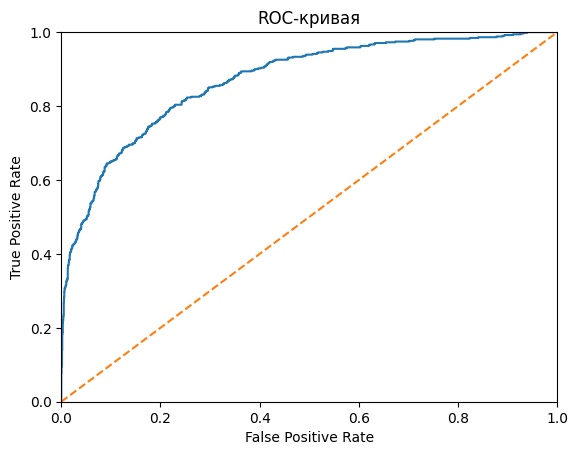

In [39]:
# plotting ROC-curve for the final model
from sklearn.metrics import roc_curve

best_model_probabilities_one = model_hgbc_up.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, best_model_probabilities_one)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

### Conclusion
The performance metrics of the HistGradientBoostingClassifier are better than those of the constant model, indicating that the model can be considered adequate.

## General Conclusion
In this study, linear regression, random forest, and extreme gradient boosting models were examined, and the target F1 metric of over 0.59 was achieved. The initial F1 metrics on the original data were as follows:

- Linear regression: 0.32
- Random forest: 0.58
- Extreme gradient boosting: 0.60

As the initial ratio of negative to positive class in the target parameter (customer churn) was 4:1, experiments were conducted with class weighting, increasing the positive class, and reducing the negative class to correct the imbalance.

The best results were achieved by increasing the minority class and using the extreme gradient boosting model. The F1 score of this model was 0.62, and the ROC_AUC was 0.76. The F1 score is 3 percentage points better than the same model before correcting the imbalance.

According to historical data, customer churn primarily depends on the age of the clients and the number of bank products used by each client. Customers over the age of 45 and those who use only one bank product are the most likely to churn.